In [116]:
import numpy as np
import matplotlib.pyplot as plt
from utils.Preprocess import Preprocess
from utils.CalculateDissimilarity import CalculateDissimilarity
from utils.GenerateSyntheticData import GenerateSyntheticData
from utils.GWOptimalTransfer import GWOptimalTransfer
import ot
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from utils.extract_paths import extract_paths

In [117]:
gen_syn = False
non_al_folder_path = './qualia_rawdata/non_alcohol/'
al_folder_path = './qualia_rawdata/alcohol/'
plot_dim = 2
comparing_pairs=('non_al', 'al')
qualia_color = {
    'romance': 'pink',
    'awe': 'green',
    'aesthetic_appreciation': 'yellow',
    'envy': 'purple',
    'amusement': 'brown',
    'guilt': 'black',
    'empatic_pain': 'orange',
    'fear': 'violet',
    'anger': 'red',
    'sadness': 'blue',
    'surprise': 'gray',
    'joy': 'cyan'
}

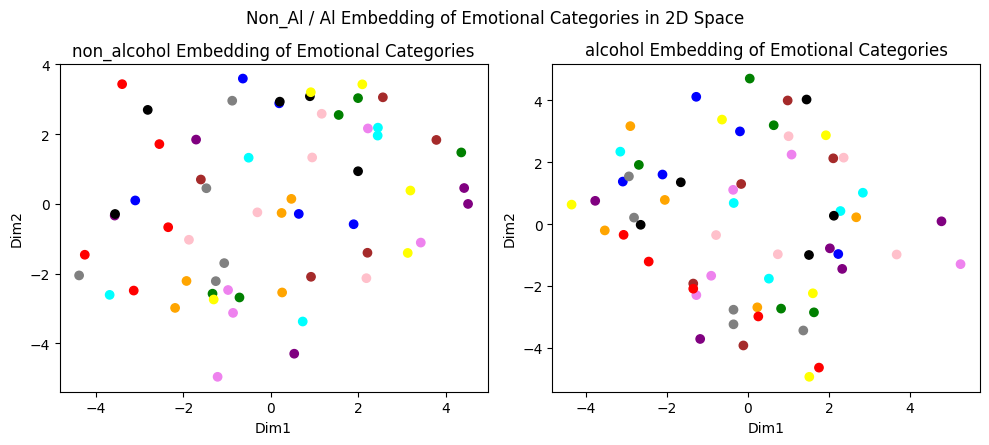

In [118]:
first_qualia_paths, second_qualia_paths = extract_paths(
        non_al_folder_path=non_al_folder_path,
        al_folder_path=al_folder_path,
        comparing_pairs=comparing_pairs
    )
all_original_embeddings_list = list()
all_dissimilarity_matrices = list()
attributes = ['non_alcohol', 'alcohol']
for paths in [first_qualia_paths, second_qualia_paths]:
    #前処理
    if gen_syn:
        """
        sample数が少なく疑似データを生成したい場合
        non_al_paths: 要素数１のlist想定、開発段階ではsample_andrew.csvのみ
        al_paths: 要素数１のlist想定、開発段階ではsample_takada.csvのみ
        """
        #pathの抽出
        path = paths[0]

        #前処理
        preprocess = Preprocess(path=path)
        sim_list, comparison_video_pairs = preprocess.extract_cols()
        preprocessed_df = preprocess.output_data(sim_list, comparison_video_pairs)
        #14個の疑似データ生成(計15samples)
        generate_synthetic_data = GenerateSyntheticData()
        preprocessed_dfs = generate_synthetic_data.generate_synthetic_data(preprocessed_df=preprocessed_df, increasing_sample_size=14)

    else:
        """
        本番用で、疑似データ生成しない場合
        non_al_paths: 要素数15のlist想定
        al_paths: 要素数15のlist想定
        """
        preprocessed_dfs = list()
        for path in paths:
            #pathで指定された被験者の実験データを前処理して出力
            preprocess = Preprocess(path=path)
            sim_list, comparison_video_pairs = preprocess.extract_cols()
            preprocessed_df = preprocess.output_data(sim_list, comparison_video_pairs)
            #保存
            preprocessed_dfs.append(preprocessed_df)

    #類似度行列を計算し、それを基にノンアル、アルコールの場合の埋め込みベクトルをそれぞれ表示
    cal_dissim = CalculateDissimilarity(preprocessed_dfs=preprocessed_dfs, qualia_color=qualia_color)
    dissimilarity_matrices = cal_dissim.dissimilarity_matrices()
    all_dissimilarity_matrices.append(np.array(dissimilarity_matrices))
    original_embeddings_list = cal_dissim.original_embeddings(dissimilarity_matrices=dissimilarity_matrices, plot_dim=plot_dim)
    #save
    all_original_embeddings_list.append(original_embeddings_list)

#ノンアル/アルコール時の埋め込みベクトルを横並びに表示
cal_dissim.plot_in_space(all_original_embeddings_list=all_original_embeddings_list , plot_dim=plot_dim, attributes=attributes)


## 最適輸送法の実装

In [99]:
#default: size=15*12*3(15*2*2)
X_embeddings = np.array(all_original_embeddings_list[0]).copy()
Y_embeddings = np.array(all_original_embeddings_list[1]).copy()

#size=3*180(2*180)に変換
sample_size, n, plot_dim = X_embeddings.shape
X_embeddings_combined = X_embeddings.reshape(sample_size*n, plot_dim).T
Y_embeddings_combined = Y_embeddings.reshape(sample_size*n, plot_dim).T
X_embeddings_combined.shape, Y_embeddings_combined.shape

((2, 12), (2, 12))

In [100]:
# コスト行列を手動で計算
def pairwise_distances(X, Y):
    return np.linalg.norm(X[:, :, np.newaxis] - Y[:, np.newaxis, :], axis=0)

C1 = pairwise_distances(X_embeddings_combined, X_embeddings_combined)
C2 = pairwise_distances(Y_embeddings_combined, Y_embeddings_combined)
# 初期分布（均等な分布を仮定）
p = np.ones((sample_size*n)) / (sample_size*n)
q = np.ones((sample_size*n)) / (sample_size*n)

# Gromov-Wasserstein距離の計算
optimal_P, log = ot.gromov.gromov_wasserstein(C2, C1, p, q, 'square_loss', log=True)
optimal_P_identical, log = ot.gromov.gromov_wasserstein(C1, C1, p, q, 'square_loss', log=True)
optimal_P_reverse, log = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', log=True)
print(optimal_P.shape)

(12, 12)


Text(627.9949494949494, 0.5, 'X Indices')

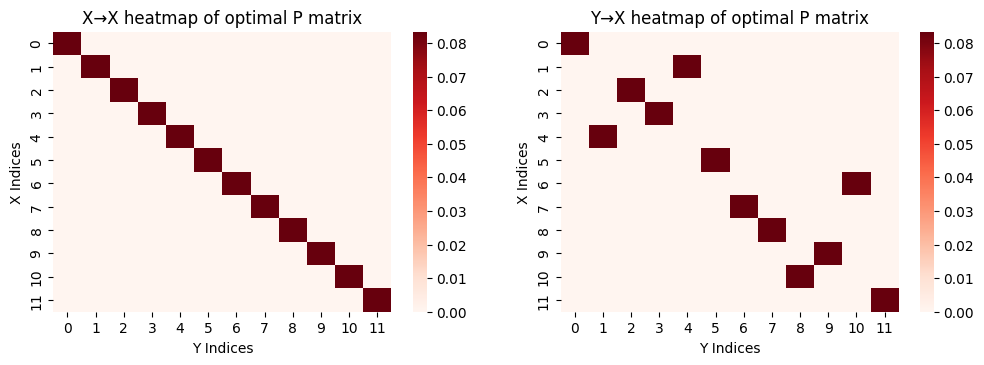

In [101]:
#optimal_Pの可視化part1
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2, 2, 1)
sns.heatmap(optimal_P_identical, cmap='Reds')
ax.set_title('X→X heatmap of optimal P matrix')
ax.set_xlabel('Y Indices')
ax.set_ylabel('X Indices')

#optimal_Pの可視化part2
ax = fig.add_subplot(2, 2, 2)
sns.heatmap(optimal_P, cmap='Reds')
ax.set_title('Y→X heatmap of optimal P matrix')
ax.set_xlabel('Y Indices')
ax.set_ylabel('X Indices')

#optimal_P_reverseの可視化part2
# ax = fig.add_subplot(2, 2, 2)
# sns.heatmap(optimal_P_reverse, cmap='Reds')
# ax.set_title('X→Y heatmap of optimal P matrix')
# ax.set_xlabel('Y Indices')
# ax.set_ylabel('X Indices')

In [91]:
optimal_P

array([[0.08333333, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.08333333,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.08333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.08333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.08333333, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.08333333, 0.        , 0.        , 0.        , 0.        ,
        0.        ,

In [ ]:
1, 2, 6, 7, 8, 9

Text(627.9949494949494, 0.5, 'X Indices')

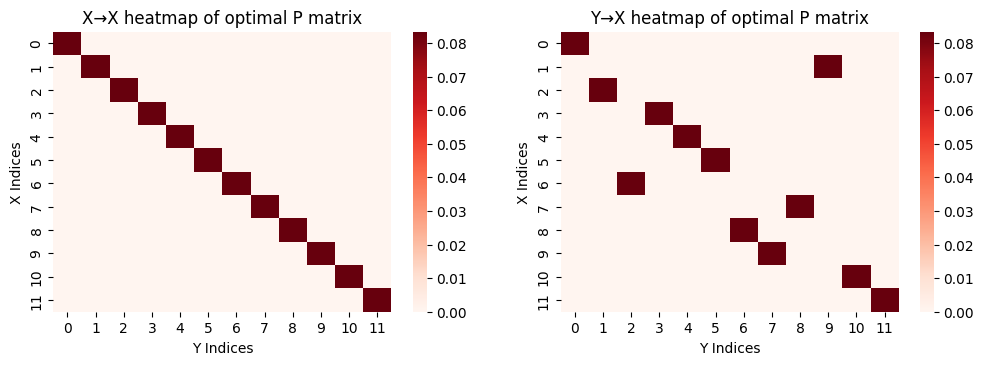

In [40]:
#optimal_Pの可視化part1
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2, 2, 1)
sns.heatmap(optimal_P_identical, cmap='Reds')
ax.set_title('X→X heatmap of optimal P matrix')
ax.set_xlabel('Y Indices')
ax.set_ylabel('X Indices')

#optimal_Pの可視化part2
ax = fig.add_subplot(2, 2, 2)
sns.heatmap(optimal_P, cmap='Reds')
ax.set_title('Y→X heatmap of optimal P matrix')
ax.set_xlabel('Y Indices')
ax.set_ylabel('X Indices')

#optimal_P_reverseの可視化part2
# ax = fig.add_subplot(2, 2, 2)
# sns.heatmap(optimal_P_reverse, cmap='Reds')
# ax.set_title('X→Y heatmap of optimal P matrix')
# ax.set_xlabel('Y Indices')
# ax.set_ylabel('X Indices')

In [7]:
#特異値分解によるQ行列の計算
# (X Y P^*)^T の計算
XYP_T = np.dot(X_embeddings_combined, np.dot(Y_embeddings_combined, optimal_P).T)

# 特異値分解
U, S, Vt = np.linalg.svd(XYP_T)

# Q* = UV^T の計算
optimal_Q = np.dot(U, Vt)

print(optimal_Q.shape)


(2, 2)


In [8]:
Y_optimal_mapped = np.dot(optimal_Q, Y_embeddings_combined)
Y_optimal_mapped.shape

(2, 180)

In [9]:
emotions = list(qualia_color.keys())
colors = list(qualia_color.values())
emotion_index = {emotion: idx for idx, emotion in enumerate(emotions)}

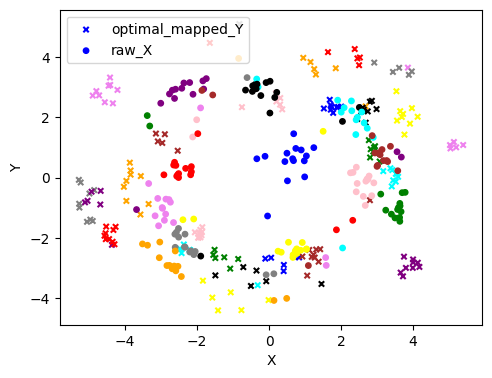

In [13]:
# 2次元プロットの準備
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(2, 2, 1)

# 座標をプロット
colors_combined = colors * sample_size
ax.scatter(Y_optimal_mapped[0], Y_optimal_mapped[1], c=colors_combined, marker='x',s=15, label='optimal_mapped_Y')

#元埋め込みも同様にプロット
colors_combined = colors * sample_size
embedding_df = pd.DataFrame(X_embeddings_combined.T, index=colors_combined, columns=['Dim1', 'Dim2'])
ax.scatter(embedding_df['Dim1'], embedding_df['Dim2'], c=colors_combined, marker='o',s=15, label='raw_X')


# 軸ラベルの設定
ax.set_xlabel('X')
ax.set_ylabel('Y')

# グラフ表示
plt.legend()
plt.show()

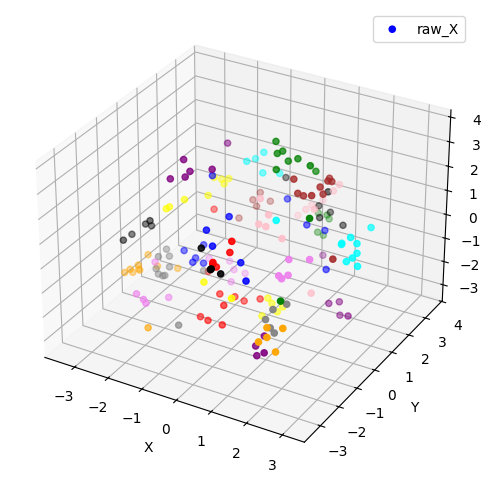

In [113]:
# 3次元プロットの準備
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 座標をプロット
colors_combined = colors * sample_size
# ax.scatter(Y_optimal_mapped[0], Y_optimal_mapped[1], Y_optimal_mapped[2], c=colors_combined, marker='x', label='optimal_mapped_Y')

#元埋め込みも同様にプロット
colors_combined = colors * sample_size
embedding_df = pd.DataFrame(X_embeddings_combined.T, index=colors_combined, columns=['Dim1', 'Dim2', 'Dim3'])
ax.scatter(embedding_df['Dim1'], embedding_df['Dim2'], embedding_df['Dim3'], c=colors_combined, marker='o', label='raw_X')


# 軸ラベルの設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# グラフ表示
plt.legend()
plt.show()

## 導通確認

In [5]:
from utils.GWOptimalTransfer import GWOptimalTransferModified

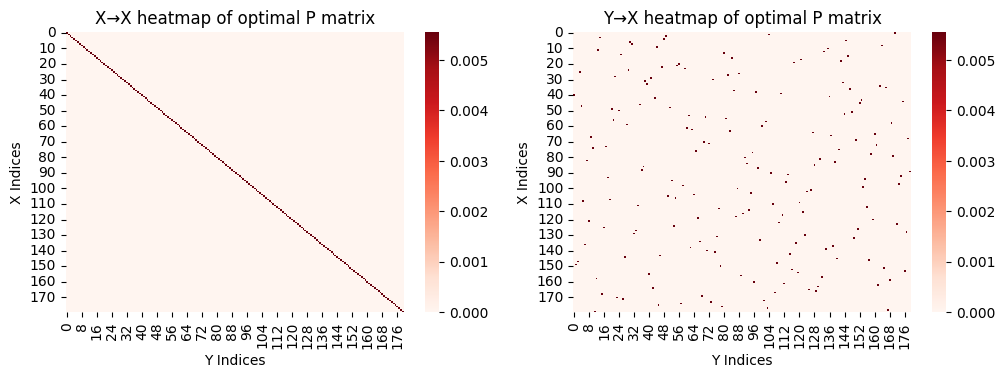

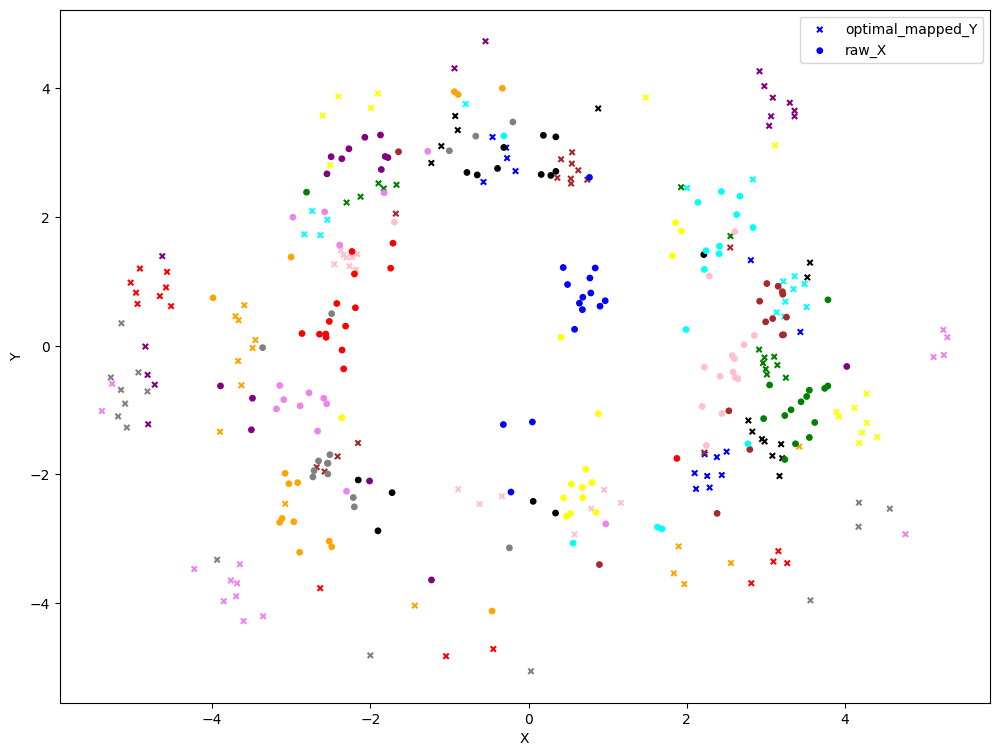

In [8]:
X_embeddings = all_original_embeddings_list[0]
Y_embeddings = all_original_embeddings_list[1]
gwot = GWOptimalTransferModified(X_embeddings=X_embeddings, Y_embeddings=Y_embeddings)
X_embeddings_combined, Y_embeddings_combined = gwot.reshape_embeddings()
optimal_P, optimal_P_identical = gwot.gromov_wasserstein(X_embeddings_combined=X_embeddings_combined, Y_embeddings_combined=Y_embeddings_combined)
gwot.plot_optimal_P_heatmap(optimal_P=optimal_P, optimal_P_identical=optimal_P_identical)
optimal_Q = gwot.calcurate_Q(X_embeddings_combined=X_embeddings_combined, Y_embeddings_combined=Y_embeddings_combined, optimal_P=optimal_P)
Y_optimal_mapped = gwot.calcurate_mapped_Y(optimal_Q=optimal_Q, Y_embeddings_combined=Y_embeddings_combined)
gwot.plot_optimal(X_embeddings_combined=X_embeddings_combined, Y_optimal_mapped=Y_optimal_mapped)

In [125]:
X_embeddings = np.array(all_original_embeddings_list[0])
Y_embeddings = np.array(all_original_embeddings_list[1])

# 既存のコード
sample_size, n, plot_dim = X_embeddings.shape

# 縦方向(列方向)にリシェイプ
X_embeddings_combined = X_embeddings.transpose(1, 0, 2).reshape(n*sample_size, plot_dim)
Y_embeddings_combined = Y_embeddings.transpose(1, 0, 2).reshape(n*sample_size, plot_dim)

In [127]:
Y_embeddings_combined.shape

(60, 2)